# Perform camera calibration

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

### Lets look at the calibration images first

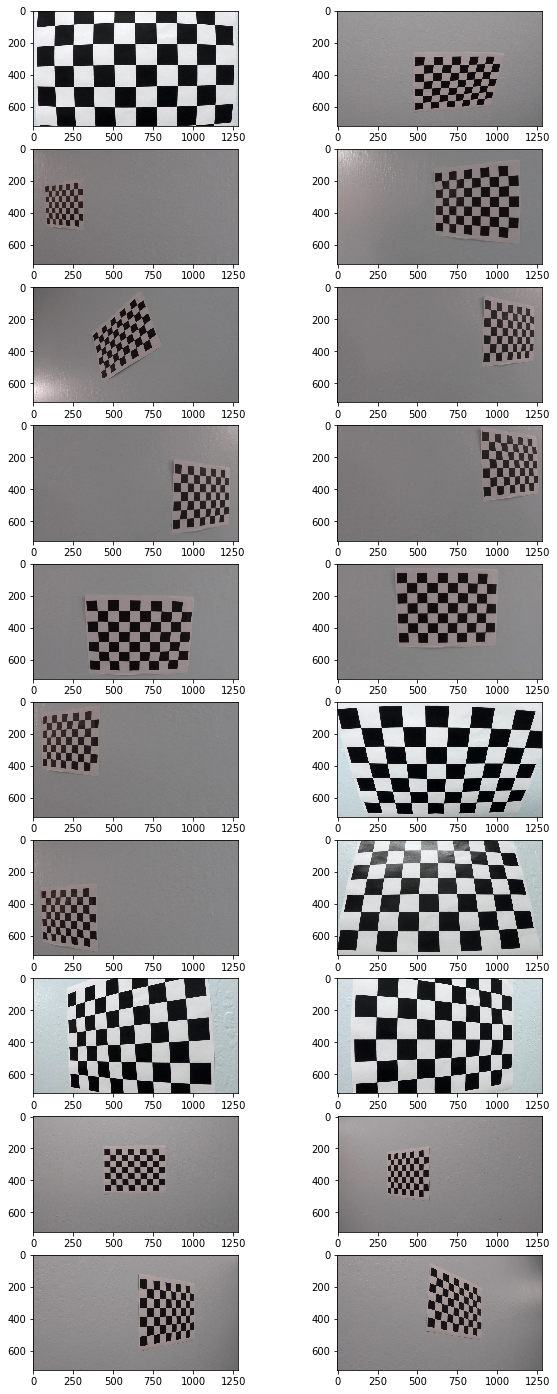

In [2]:
# Make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

plt.figure(figsize=(10, 25))

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
        
    plt.subplot(len(images)//2, 2, idx+1)
    plt.imshow(img)

### Find the chessboard corners and display
Note that some of these calibration images are not displaying the full 9 x 6 grid of corners so the corners cannot be found.

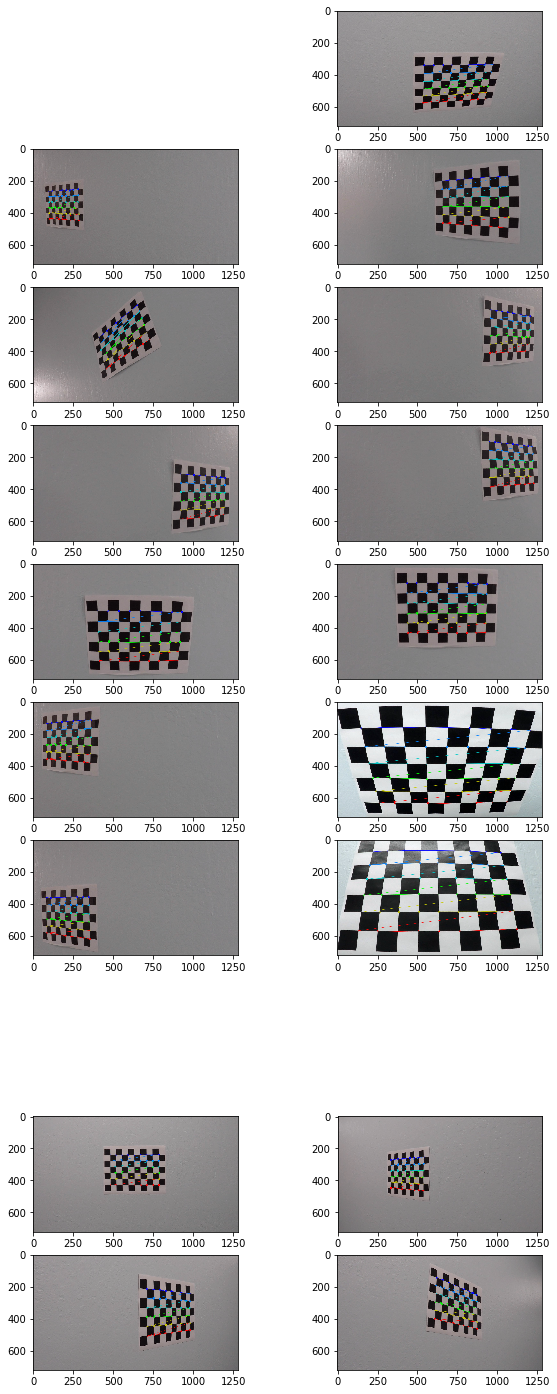

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

plt.figure(figsize=(10, 25))

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        
        plt.subplot(len(images)//2, 2, idx+1)
        plt.imshow(img)

### Some helper functions

In [4]:
def write_image(img, file):
    """
    Write image to a file
    
    img - RGB image
    """
    bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(file, bgr_img)

In [5]:
def undistort_image(img, objp, imgp):
    """
    Undistort and image based on the provided camera calibrbation factors.
    
    img - image (RGB)
    """
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [6]:
def warp_image(img, src, dst, image_size):
    """
    Apply perspective transform
    
    img: image to transform
    src: source coordinates
    dst: destination coordinates
    image_size: tuple (width, height)
    returns: tuple of the warped image, the transform matrix and inverse transform matrix
    """
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

### Un-distort a sample camera calibration image
Using the detected corners and a set of image points, we now undistort the images to correct the camera images.

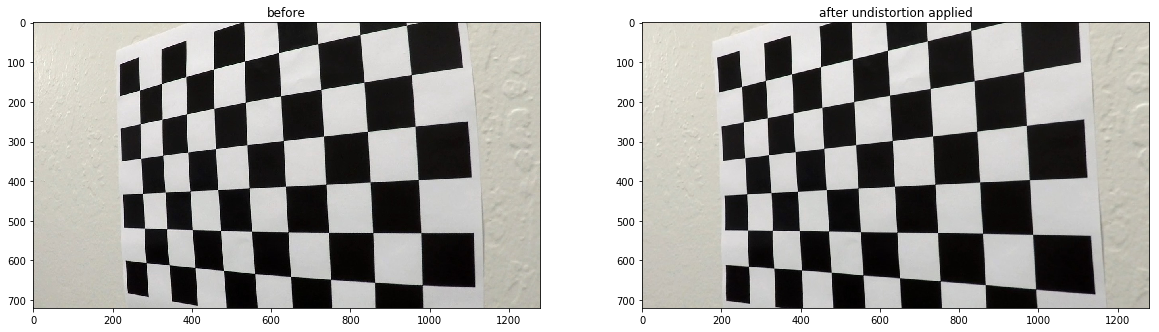

In [7]:
# Test undistortion on an image
img = cv2.imread("camera_cal/calibration4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = undistort_image(img, objpoints, imgpoints)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("before")
plt.subplot(1, 2, 2)
plt.imshow(dst)
plt.title("after undistortion applied");

write_image(dst, "output_images/camera_calibration.jpg")

### Lets undistort a test image now
Notice how the position of the white car moves...

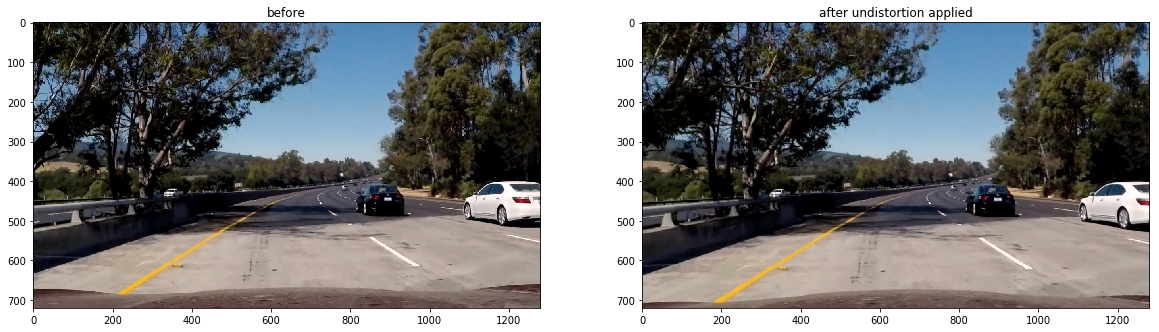

In [8]:
# Test undistortion on an image
test_img = cv2.imread("test_images/test5.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_dst = undistort_image(test_img, objpoints, imgpoints)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("before")
plt.subplot(1, 2, 2)
plt.imshow(test_dst)
plt.title("after undistortion applied");

write_image(test_dst, "output_images/undistort_test_image.jpg")

# Perspective transform
Lets apply a perspective transform to the image above to get a birds eye view

### Construct source and destination points in the image for determing the perspective transform matrix
I plot the selected points below on a test image. Note that I have chosen to pick out a trapezoid region of the road looking forward (similar to how I masked out all but a trapezoid region in the first lane finding project) as the source points. Then for the detination points I have used the full rectangle of the image.

The trapezoid for the source points was determined by trial and error to nicely include the lane lines (only) looking forward into the distance.

image shape: (720, 1280, 3)
source points:
 [[  150.   720.]
 [ 1130.   720.]
 [  750.   480.]
 [  530.   480.]]
destination points:
 [[  150.   720.]
 [ 1130.   720.]
 [ 1130.     0.]
 [  150.     0.]]


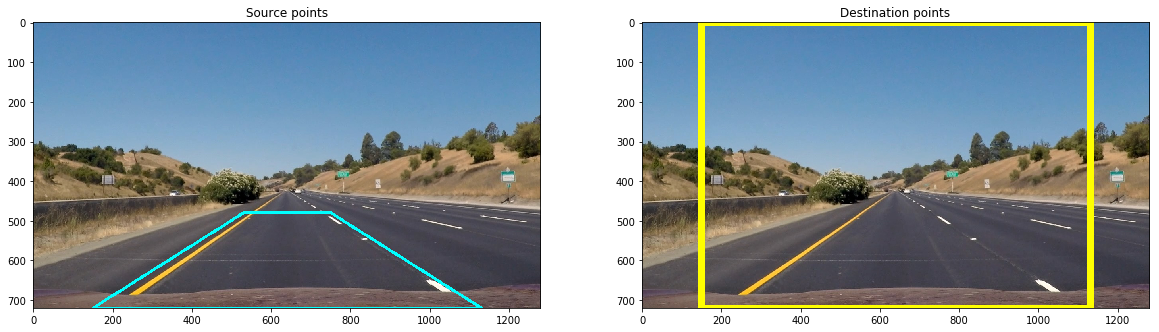

In [9]:
image = cv2.imread("test_images/straight_lines1.jpg")
print("image shape:", image.shape)

# Construct source and destination points as the basis for the perspective transform
center_point = np.uint(image.shape[1]/2)
y_top = np.uint(image.shape[0]/1.5)

x_top_left = center_point - .25*np.uint(image.shape[1]/2) + 50
x_top_right = center_point + .25*np.uint(image.shape[1]/2) - 50
x_bottom_left = center_point - 1*np.uint(image.shape[1]/2) + 150
y_bottom_left = np.uint(image.shape[0])
x_bottom_right = np.uint(image.shape[1]) - 150

# trapezoid following road lines
src = np.float32([[x_bottom_left, y_bottom_left],
                  [x_bottom_right, y_bottom_left],
                  [x_top_right, y_top],
                  [x_top_left, y_top]])
print("source points:\n", src)

# rectangle around entire image
#dst = np.float32([[0, image.shape[0]],
#                  [image.shape[1], image.shape[0]],
#                  [image.shape[1], 0],
#                  [0, 0]])
#dst = np.float32([[0+170, image.shape[0]],
#                  [image.shape[1]-170, image.shape[0]],
#                  [image.shape[1]-170, 0],
#                  [0+170, 0]])
dst = np.float32([[x_bottom_left, image.shape[0]],
                  [x_bottom_right, image.shape[0]],
                  [x_bottom_right, 0],
                  [x_bottom_left, 0]])
print("destination points:\n", dst)

# Plot the chosen source and destination points on the original image
points_image_src = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points_image_dst = points_image_src.copy()


src_pts = src.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_src, [src_pts], True, (0, 255, 255), thickness=5)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(points_image_src)
plt.title("Source points")

dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_dst, [dst_pts], True, (255, 255, 0), thickness=15)

plt.subplot(1, 2, 2)
plt.imshow(points_image_dst)
plt.title("Destination points");

### Using the src/dst image points lets warp a test image
Undistort first (we will always use undistored images from now on).

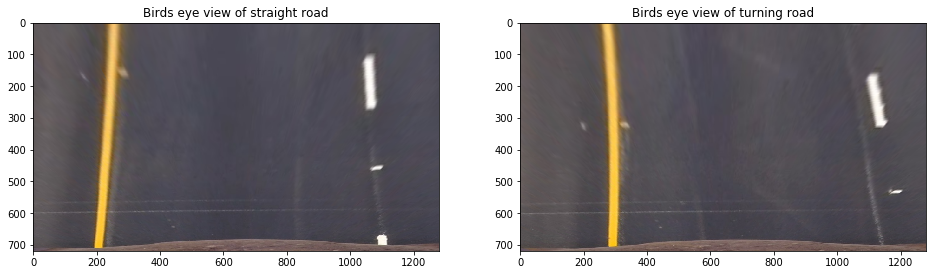

In [10]:
# Read in the same test image as used above and plot
image = cv2.imread("test_images/straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = undistort_image(image, objpoints, imgpoints)
warped, _, _ = warp_image(image, src, dst, (image.shape[1], image.shape[0]))
write_image(warped, "output_images/warped_test_straight.jpg")

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(warped)
plt.title("Birds eye view of straight road");

# Read in an image with straight lane lines to check the warped lines are parallel
image2 = cv2.imread("test_images/test2.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image2 = undistort_image(image2, objpoints, imgpoints)
warped2, _, _ = warp_image(image2, src, dst, (image2.shape[1], image2.shape[0]))
write_image(warped2, "output_images/warped_test.jpg")

plt.subplot(1, 2, 2)
plt.imshow(warped2)
plt.title("Birds eye view of turning road");

<span style="color:green">The figure above right is the warp of an image of a stright line section of road. The fact that these lines look reasonable parallel is a sign that we are warping correctly. However I don't want to fine tune the src points to tightly as then the warp may not generalise to other road segments well...</span>

# Finding lane lines with a thresholded binary image

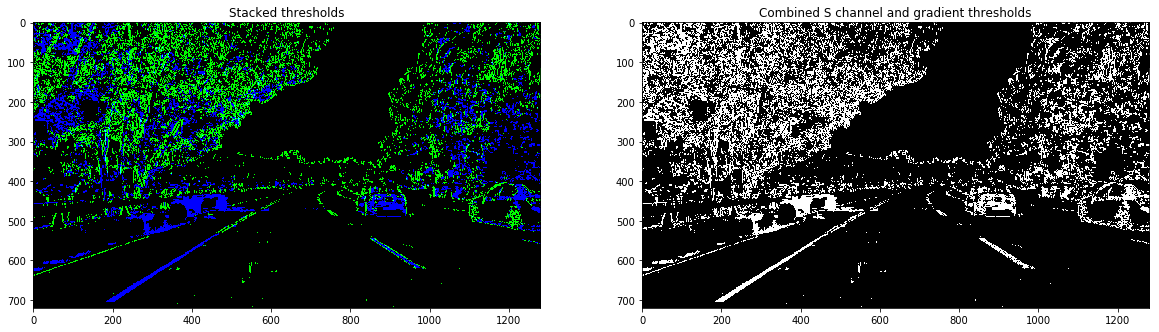

In [14]:
img = cv2.imread("test_images/test5.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = undistort_image(img, objpoints, imgpoints)

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype("float")
s_channel = hls[:,:,2]

# Sobel x
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Stacked thresholds")
ax1.imshow(color_binary)

ax2.set_title("Combined S channel and gradient thresholds")
ax2.imshow(combined_binary, cmap="gray")